# load and process data

In [45]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import tqdm
from itertools import combinations


In [46]:
genre_sentiment = pd.read_csv('../genre_sentiment_scores.csv')
movie_sentiment = pd.read_csv('../movie_sentiment_scores.csv')
rating_vs_sentiment = pd.read_csv('../movie_ratings_vs_sentiments.csv')
reviews = pd.read_csv('../sampled_reviews.csv')

scores = pd.read_csv('../grouplens_data/ml-latest/genome-scores.csv')
tags = pd.read_csv('../grouplens_data/ml-latest/genome-tags.csv')
links = pd.read_csv('../grouplens_data/ml-latest/links.csv')
movies = pd.read_csv('../grouplens_data/ml-latest/movies.csv')
ratings = pd.read_csv('../grouplens_data/ml-latest/ratings.csv')

# movies.set_index("movieId", inplace=True)
# rating_vs_sentiment.set_index("movieId", inplace=True)
# movie_sentiment.set_index("movieId", inplace=True)
# scores.set_index("movieId", inplace=True)
# links.set_index("movieId", inplace=True)





In [47]:
# Assuming all the DataFrames are already loaded

# Merge the relevant data into a single DataFrame by `movieId`
nested_df = pd.merge(movies, movie_sentiment, on="movieId", how="left")

In [48]:
nested_df = pd.merge(nested_df, rating_vs_sentiment, on="movieId", how="left", suffixes=("", "_rating"))


In [49]:
nested_df = pd.merge(nested_df, links, on="movieId", how="left")


In [50]:
nested_df = nested_df[nested_df['average_sentiment'].notna()]

In [51]:
ratings = ratings[ratings['movieId'].isin(nested_df['movieId'])]


In [52]:
reviews = reviews[reviews['movieId'].isin(nested_df['movieId'])]

In [53]:
scores = scores[scores['movieId'].isin(nested_df['movieId'])]

In [54]:
ratings_nested = ratings.groupby('movieId').apply(lambda x: x[['userId', 'rating', 'timestamp']].to_dict(orient='records')).reset_index(name='ratings')


/var/folders/06/l7w93lb13l7f94htvwv84z2c0000gn/T/ipykernel_28852/2434976666.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratings_nested = ratings.groupby('movieId').apply(lambda x: x[['userId', 'rating', 'timestamp']].to_dict(orient='records')).reset_index(name='ratings')


In [55]:
reviews_nested = reviews.groupby('movieId').apply(lambda x: x[['review']].to_dict(orient='records')).reset_index(name='reviews')

/var/folders/06/l7w93lb13l7f94htvwv84z2c0000gn/T/ipykernel_28852/1395610327.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reviews_nested = reviews.groupby('movieId').apply(lambda x: x[['review']].to_dict(orient='records')).reset_index(name='reviews')


In [56]:
tags_nested = scores.merge(tags, on='tagId').groupby('movieId').apply(lambda x: x[['tag', 'relevance']].to_dict(orient='records')).reset_index(name='tags')


/var/folders/06/l7w93lb13l7f94htvwv84z2c0000gn/T/ipykernel_28852/2480635341.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tags_nested = scores.merge(tags, on='tagId').groupby('movieId').apply(lambda x: x[['tag', 'relevance']].to_dict(orient='records')).reset_index(name='tags')


In [57]:
nested_df = pd.merge(nested_df, ratings_nested, on="movieId", how="left")


In [58]:
nested_df = pd.merge(nested_df, reviews_nested, on="movieId", how="left")


In [59]:
nested_df = pd.merge(nested_df, tags_nested, on="movieId", how="left")


In [60]:
nested_df = nested_df[['movieId', 'title', 'genres', 'average_sentiment', 'ratings', 'reviews', 'tags','average_rating']]


# Network

In [61]:
G = nx.Graph()



In [62]:
# filtered_movies = rating_vs_sentiment[rating_vs_sentiment['rating_count'] > 30000]
# filtered_movie_ids = set(filtered_movies['movieId'])


In [63]:
for _, row in nested_df.iterrows():
    # if row['movieId'] in filtered_movie_ids:
    G.add_node(
        f"movie_{row['movieId']}",
        type="movie",
        title=row['title'],
        genres=row['genres'].split('|'),  # Split genres into a list
        average_sentiment=row['average_sentiment'],  # Placeholder
        average_rating=row['average_rating']  # Placeholder
    )


In [64]:
# Add sentiment
for _, row in movie_sentiment.iterrows():
    movie_node = f"movie_{row['movieId']}"
    if G.has_node(movie_node):
        G.nodes[movie_node]['average_sentiment'] = row['average_sentiment']

# Add rating
for _, row in rating_vs_sentiment.iterrows():
    movie_node = f"movie_{row['movieId']}"
    if G.has_node(movie_node):
        G.nodes[movie_node]['average_rating'] = row['average_rating']


In [65]:
def genre_overlap(movie1_genres, movie2_genres):
    return len(set(movie1_genres).intersection(set(movie2_genres)))


In [66]:
def tag_similarity(movie1, movie2, scores_df):
    tags1 = scores_df[scores_df['movieId'] == movie1]
    tags2 = scores_df[scores_df['movieId'] == movie2]
    shared_tags = set(tags1['tagId']).intersection(set(tags2['tagId']))

    # Calculate cumulative relevance for shared tags
    relevance1 = tags1[tags1['tagId'].isin(shared_tags)]['relevance'].sum()
    relevance2 = tags2[tags2['tagId'].isin(shared_tags)]['relevance'].sum()

    return relevance1 + relevance2


In [67]:
sentiment_threshold = 0.1  # Allowable difference in sentiment
rating_threshold = 0.5    # Allowable difference in rating


In [68]:
movie_ids = nested_df['movieId'].unique()
print(len(movie_ids) * len(movie_ids))

783225


In [69]:

for movie1, movie2 in tqdm.tqdm(combinations(movie_ids, 2)):
    node1 = f"movie_{movie1}"
    node2 = f"movie_{movie2}"
    
    # Check if both nodes exist
    if G.has_node(node1) and G.has_node(node2):
        # Get node attributes
        genres1 = G.nodes[node1]['genres']
        genres2 = G.nodes[node2]['genres']
        sentiment1 = G.nodes[node1]['average_sentiment']
        sentiment2 = G.nodes[node2]['average_sentiment']
        rating1 = G.nodes[node1]['average_rating']
        rating2 = G.nodes[node2]['average_rating']
        
        # Calculate similarities
        genre_score = genre_overlap(genres1, genres2)
        # print(genre_score)
        # tag_score = tag_similarity(movie1, movie2, scores)
        # print(tag_score)
        if genre_score > 0:
            G.add_edge(node1,node2)

        # # print(sentiment1)
        # # print(sentiment2)
        # # print()
        # sentiment_score = abs(sentiment1 - sentiment2) if sentiment1 and sentiment2 else None
        # rating_score = abs(rating1 - rating2) if rating1 and rating2 else None
        
        # # Check thresholds
        # if genre_score > 0 or tag_score > 0:  # At least some overlap
        #     if (sentiment_score is None or sentiment_score <= sentiment_threshold) and \
        #        (rating_score is None or rating_score <= rating_threshold):
        #         # Add edge
        #         G.add_edge(
        #             node1, node2,
        #             weight=genre_score + tag_score,  # Combined similarity score
        #             genre_overlap=genre_score,
        #             tag_similarity=tag_score,
        #             sentiment_difference=sentiment_score,
        #             rating_difference=rating_score
        #         )


0it [00:00, ?it/s]

391170it [00:00, 438803.86it/s]


In [70]:
print("Network Insights:")
print(f"- Number of nodes (movies): {G.number_of_nodes()}")
print(f"- Number of edges (connections): {G.number_of_edges()}")

Network Insights:
- Number of nodes (movies): 885
- Number of edges (connections): 201412


In [71]:
from networkx.algorithms.community import greedy_modularity_communities

communities = greedy_modularity_communities(G)
print(f"Number of Communities: {len(communities)}")


Number of Communities: 3


In [72]:
# Degree centrality (most connected movies)
degree_centrality = nx.degree_centrality(G)
top_movies = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("- Top connected movies based on degree centrality:")
for movie_id, centrality in top_movies:
    print(f"  {G.nodes[movie_id]['title']} with centrality {centrality:.2f}")


- Top connected movies based on degree centrality:
  Ghost (1990) with centrality 0.89
  Lords of Dogtown (2005) with centrality 0.88
  Knives Out (2019) with centrality 0.86
  Pulp Fiction (1994) with centrality 0.86
  Fargo (1996) with centrality 0.86


In [73]:
centrality = nx.degree_centrality(G)
top_central_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 Central Movies:", top_central_nodes)


Top 10 Central Movies: [('movie_587', 0.8936651583710408), ('movie_33672', 0.8846153846153847), ('movie_207313', 0.8597285067873304), ('movie_296', 0.8585972850678734), ('movie_608', 0.8585972850678734), ('movie_57669', 0.8585972850678734), ('movie_49530', 0.8518099547511313), ('movie_45672', 0.8506787330316743), ('movie_79796', 0.8450226244343892), ('movie_48774', 0.8427601809954752)]


In [74]:
avg_clustering = nx.average_clustering(G)
print("Average Clustering Coefficient:", avg_clustering)


Average Clustering Coefficient: 0.8094644148573137


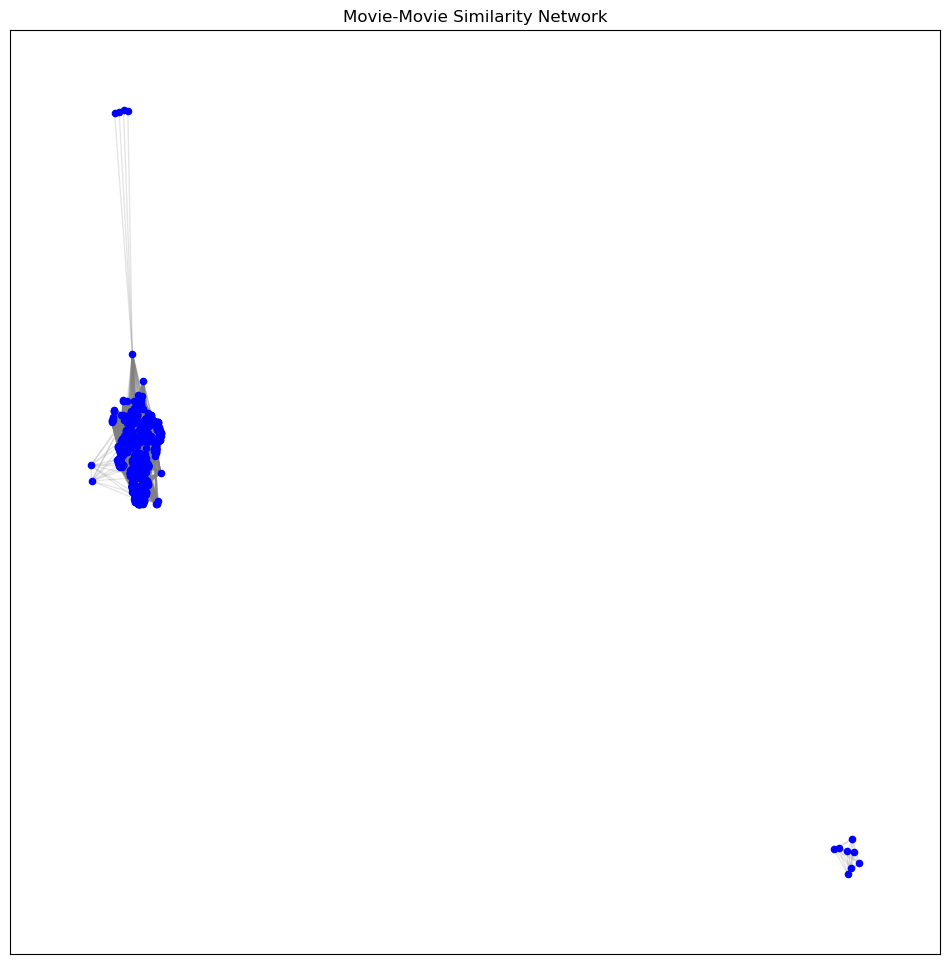

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # Spring layout for better aesthetics
nx.draw_networkx_nodes(G, pos, node_size=20, node_color="blue")
nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color="gray")
plt.title("Movie-Movie Similarity Network")
plt.show()


# largest component

In [76]:
# Find all connected components (returns sets of nodes)
connected_components = list(nx.connected_components(G))

# Find the largest connected component
largest_component_nodes = max(connected_components, key=len)

# Create a subgraph of the largest connected component
largest_component = G.subgraph(largest_component_nodes).copy()

In [77]:
from networkx.algorithms.community import louvain_communities

communities = louvain_communities(largest_component, weight=None)
print(f"Number of communities detected: {len(communities)}")

Number of communities detected: 4


In [78]:
largest_component.nodes

NodeView(('movie_1', 'movie_6', 'movie_16', 'movie_48', 'movie_62', 'movie_70', 'movie_104', 'movie_110', 'movie_111', 'movie_150', 'movie_215', 'movie_235', 'movie_253', 'movie_260', 'movie_266', 'movie_296', 'movie_300', 'movie_356', 'movie_377', 'movie_475', 'movie_480', 'movie_524', 'movie_527', 'movie_541', 'movie_553', 'movie_555', 'movie_586', 'movie_587', 'movie_588', 'movie_589', 'movie_594', 'movie_595', 'movie_597', 'movie_608', 'movie_648', 'movie_665', 'movie_673', 'movie_750', 'movie_760', 'movie_778', 'movie_785', 'movie_899', 'movie_903', 'movie_904', 'movie_908', 'movie_910', 'movie_912', 'movie_920', 'movie_923', 'movie_924', 'movie_946', 'movie_953', 'movie_1022', 'movie_1032', 'movie_1036', 'movie_1042', 'movie_1066', 'movie_1080', 'movie_1088', 'movie_1089', 'movie_1090', 'movie_1097', 'movie_1100', 'movie_1136', 'movie_1178', 'movie_1193', 'movie_1196', 'movie_1200', 'movie_1203', 'movie_1204', 'movie_1207', 'movie_1208', 'movie_1210', 'movie_1213', 'movie_1214', 

In [79]:
node_id = 'movie_1'  # Replace with the specific node ID you want to inspect
print(f"Attributes of node {node_id}:")
print(G.nodes[node_id])


Attributes of node movie_1:
{'type': 'movie', 'title': 'Toy Story (1995)', 'genres': ['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy'], 'average_sentiment': 5.592884160038165, 'average_rating': 3.893507609389036}


In [80]:
# Analyze sentiments in each community
community_sentiments = []
for i, community in enumerate(communities):
    community_nodes = largest_component.subgraph(community)
    sentiments = [largest_component.nodes[node]['average_sentiment'] for node in community]
    avg_sentiment = sum(sentiments) / len(sentiments)
    community_sentiments.append({'community': i + 1, 'nodes': list(community), 'avg_sentiment': avg_sentiment})
    print(f"Community {i + 1}:")
    print(f"  - Movies: {[largest_component.nodes[node]['title'] for node in community]}")
    print(f"  - Average Sentiment: {avg_sentiment:.2f}")

Community 1:
  - Movies: ['Life Is Beautiful (2013)', 'Hitch (2005)', 'War Machine (2017)', 'Puss in Boots (2011)', '50 First Dates (2004)', 'Rango (2011)', 'Warm Bodies (2013)', 'Horrible Bosses (2011)', 'Corpse Bride (2005)', 'Monty Python and the Holy Grail (1975)', 'Minions (2015)', 'Tangled (2010)', 'Life (1999)', 'Shall We Dance (1937)', "We're the Millers (2013)", 'The Lego Movie (2014)', 'Finding Nemo (2003)', 'Coffee and Cigarettes (2003)', 'Ice Age: Dawn of the Dinosaurs (2009)', 'Walk Hard: The Dewey Cox Story (2007)', 'The Happening (1967)', 'Tropic Thunder (2008)', 'I Love You, Man (2009)', 'Wreck-It Ralph (2012)', "Nick and Norah's Infinite Playlist (2008)", 'Garden State (2004)', 'Bolt (2008)', 'Detroit Rock City (1999)', 'Little Boy (2015)', 'Spice World (1997)', 'Groundhog Day (1993)', "Singin' in the Rain (1952)", 'The Secret Life of Pets (2016)', 'Shrek 2 (2004)', 'Underworld (1996)', 'Balls of Fury (2007)', 'To Be or Not to Be (1942)', 'Knives Out (2019)', 'Love and

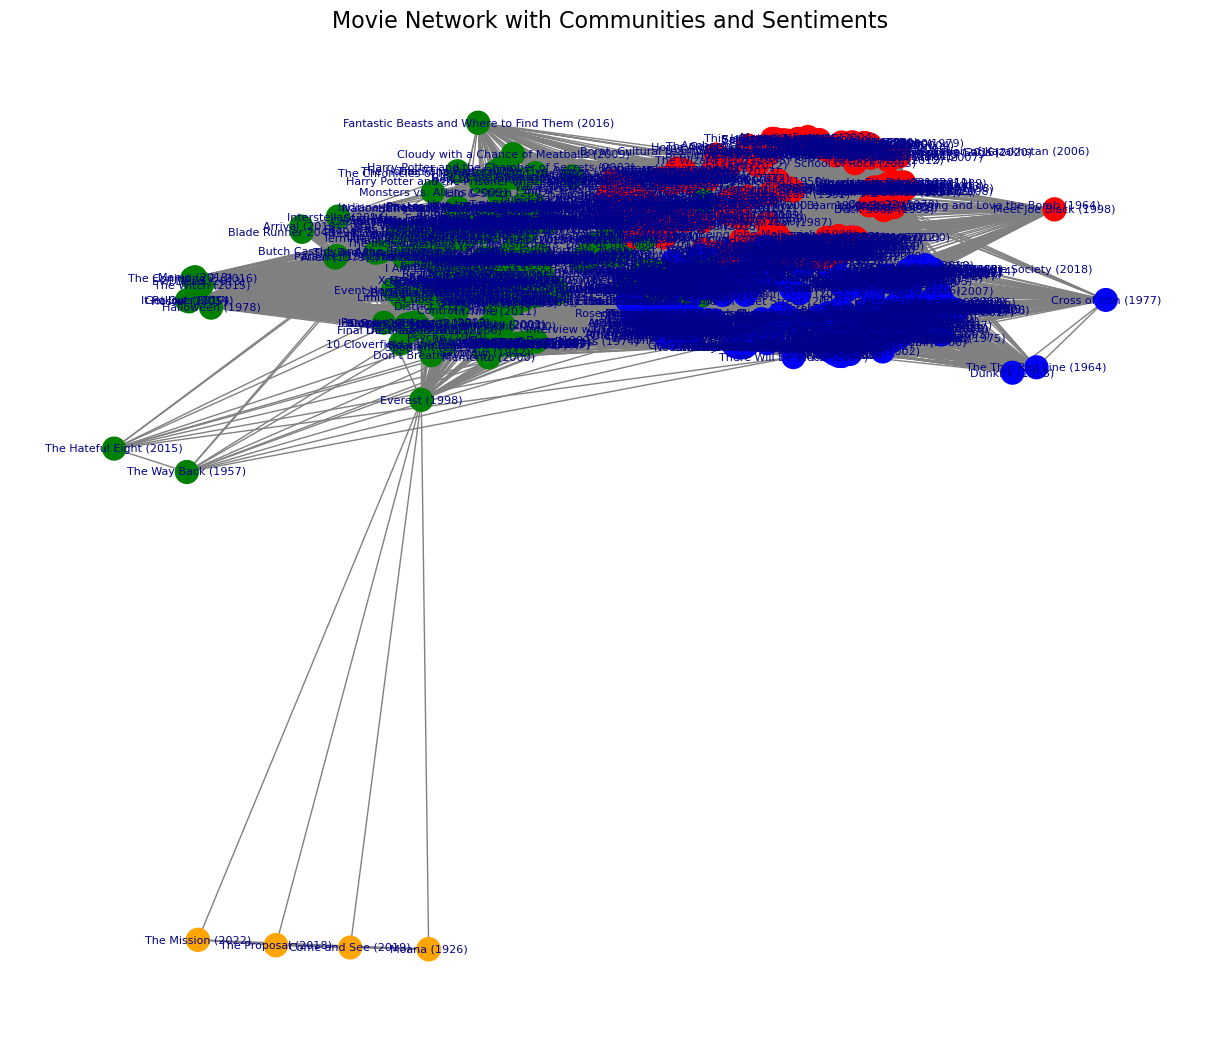

In [81]:
# Visualize the network with community colors and sentiment node sizes
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(largest_component, seed=42)  # Layout for consistent positioning

# Assign colors to communities
colors = ['red', 'blue', 'green', 'orange', 'purple']
node_colors = []
node_sizes = []

for node in largest_component.nodes:
    for i, community in enumerate(communities):
        if node in community:
            node_colors.append(colors[i % len(colors)])
            break
    # Use sentiment to determine node size
    node_sizes.append(largest_component.nodes[node]['average_sentiment'] * 50)  # Scale sentiment for visualization

# Draw the network
nx.draw(
    largest_component, pos,
    with_labels=True,
    labels=nx.get_node_attributes(largest_component, 'title'),
    node_size=node_sizes,
    node_color=node_colors,
    font_size=8,
    font_color='darkblue',
    edge_color='gray'
)
plt.title("Movie Network with Communities and Sentiments", fontsize=16)
plt.show()

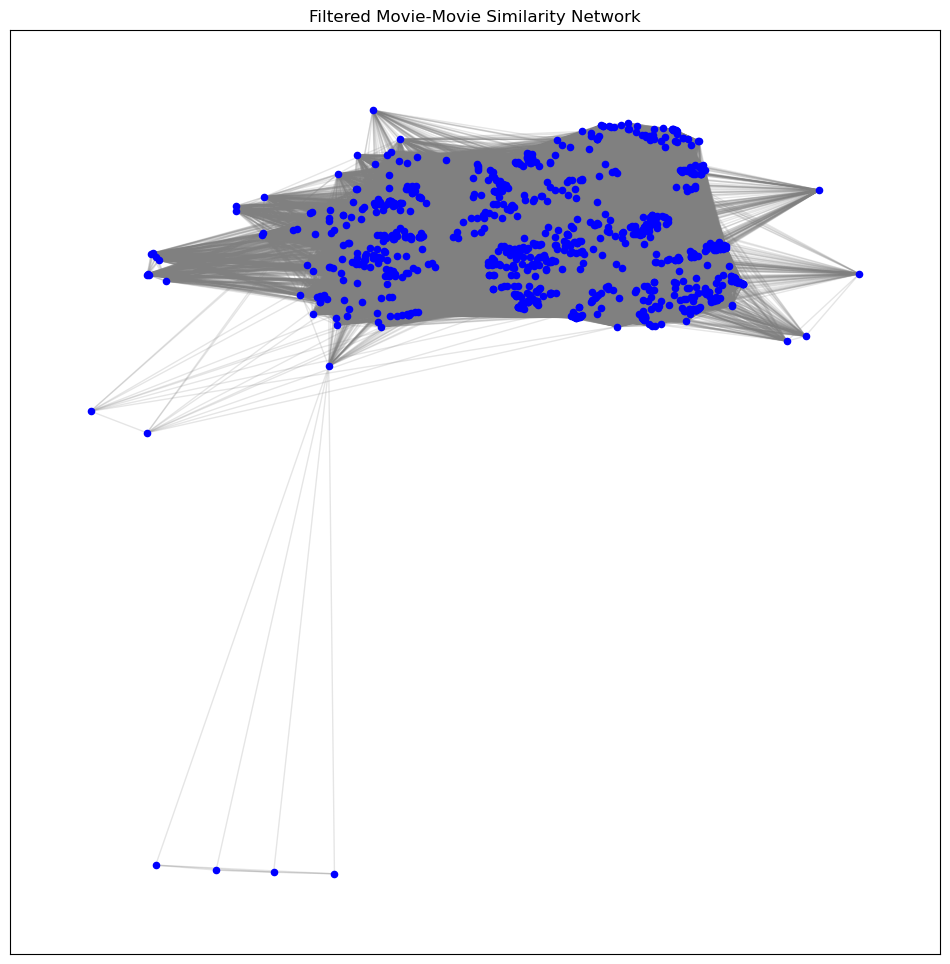

In [82]:

# Plot the filtered graph
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(largest_component, seed=42)  # Spring layout for better aesthetics
nx.draw_networkx_nodes(largest_component, pos, node_size=20, node_color="blue")
nx.draw_networkx_edges(largest_component, pos, alpha=0.2, edge_color="gray")
plt.title("Filtered Movie-Movie Similarity Network")
plt.show()


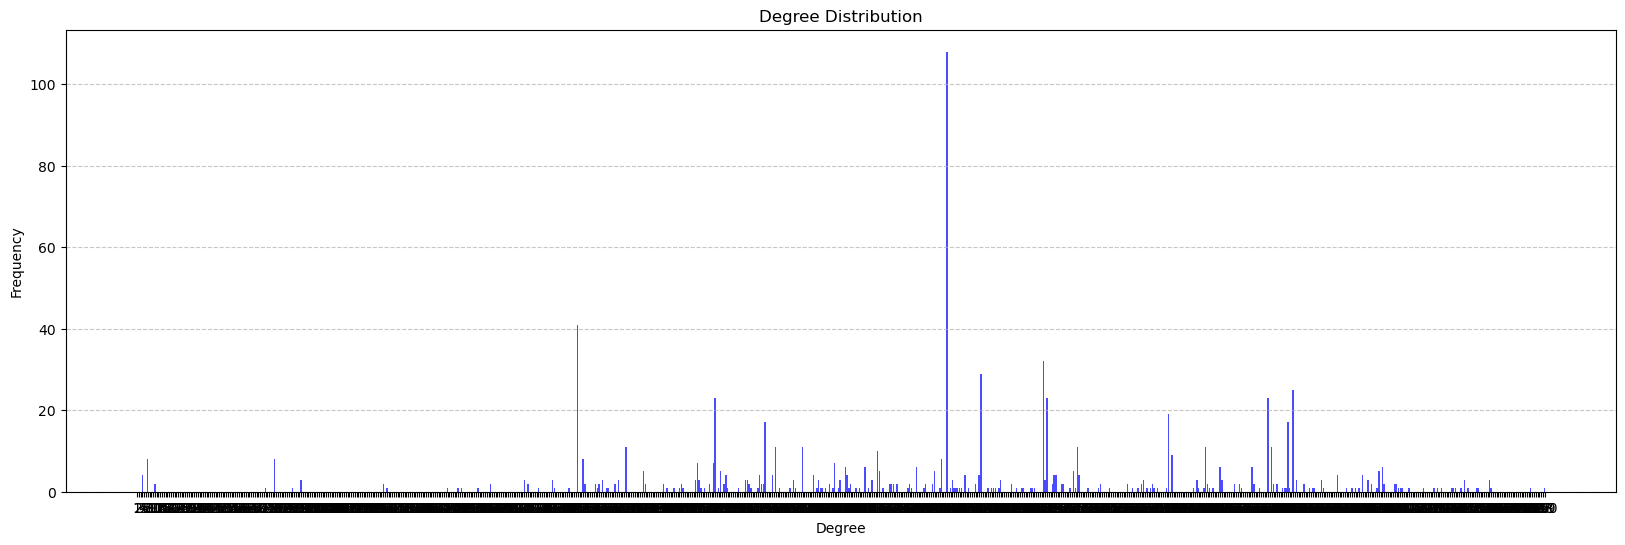

In [83]:
import matplotlib.pyplot as plt

# Calculate the degree of each node
degree_sequence = [degree for _, degree in G.degree()]

# Plot the degree distribution
plt.figure(figsize=(20, 6))
plt.hist(degree_sequence, bins=range(1, max(degree_sequence) + 2), align='left', rwidth=0.8, color='blue', alpha=0.7)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.xticks(range(1, max(degree_sequence) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [84]:
G.degree()

DegreeView({'movie_1': 409, 'movie_6': 416, 'movie_16': 511, 'movie_48': 573, 'movie_62': 455, 'movie_70': 593, 'movie_104': 248, 'movie_110': 646, 'movie_111': 600, 'movie_150': 626, 'movie_215': 509, 'movie_235': 635, 'movie_253': 519, 'movie_260': 353, 'movie_266': 534, 'movie_296': 759, 'movie_300': 455, 'movie_356': 660, 'movie_377': 502, 'movie_475': 455, 'movie_480': 452, 'movie_524': 455, 'movie_527': 474, 'movie_541': 398, 'movie_553': 640, 'movie_555': 275, 'movie_586': 269, 'movie_587': 790, 'movie_588': 401, 'movie_589': 296, 'movie_594': 578, 'movie_595': 302, 'movie_597': 325, 'movie_608': 759, 'movie_648': 451, 'movie_665': 646, 'movie_673': 473, 'movie_750': 328, 'movie_760': 474, 'movie_778': 674, 'movie_785': 248, 'movie_899': 331, 'movie_903': 630, 'movie_904': 234, 'movie_908': 567, 'movie_910': 343, 'movie_912': 509, 'movie_920': 528, 'movie_923': 485, 'movie_924': 655, 'movie_946': 646, 'movie_953': 596, 'movie_1022': 264, 'movie_1032': 259, 'movie_1036': 416, 'mo

In [85]:
G.edges

EdgeView([('movie_1', 'movie_48'), ('movie_1', 'movie_70'), ('movie_1', 'movie_104'), ('movie_1', 'movie_150'), ('movie_1', 'movie_235'), ('movie_1', 'movie_260'), ('movie_1', 'movie_296'), ('movie_1', 'movie_356'), ('movie_1', 'movie_480'), ('movie_1', 'movie_586'), ('movie_1', 'movie_587'), ('movie_1', 'movie_588'), ('movie_1', 'movie_594'), ('movie_1', 'movie_595'), ('movie_1', 'movie_597'), ('movie_1', 'movie_608'), ('movie_1', 'movie_648'), ('movie_1', 'movie_665'), ('movie_1', 'movie_673'), ('movie_1', 'movie_750'), ('movie_1', 'movie_778'), ('movie_1', 'movie_785'), ('movie_1', 'movie_899'), ('movie_1', 'movie_908'), ('movie_1', 'movie_910'), ('movie_1', 'movie_924'), ('movie_1', 'movie_946'), ('movie_1', 'movie_953'), ('movie_1', 'movie_1022'), ('movie_1', 'movie_1032'), ('movie_1', 'movie_1042'), ('movie_1', 'movie_1066'), ('movie_1', 'movie_1080'), ('movie_1', 'movie_1097'), ('movie_1', 'movie_1136'), ('movie_1', 'movie_1196'), ('movie_1', 'movie_1200'), ('movie_1', 'movie_12

In [86]:
movies[movies['movieId'] == 588]

movieId           title                                       genres
580      588  Aladdin (1992)  Adventure|Animation|Children|Comedy|Musical

In [87]:
movies[movies['movieId'] == 1]

movieId             title                                       genres
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy